In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

In [2]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# EDA

In [3]:
url = "https://raw.githubusercontent.com/ataislucky/Data-Science/main/dataset/ad_ctr.csv"
data = pd.read_csv(url)
display(data.head())
print(data.shape)

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,Male,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,Male,Singapore,2016-01-16 17:56:05,0
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,Female,Guadeloupe,2016-06-29 10:50:45,0
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,Female,Zambia,2016-06-21 14:32:32,0
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,Female,Qatar,2016-07-21 10:54:35,1


(10000, 10)


In [4]:
data["Clicked on Ad"].value_counts(normalize=True)

0    0.5083
1    0.4917
Name: Clicked on Ad, dtype: float64

# Feature Engineering

In [5]:
for i in ['Ad Topic Line', 'City', 'Gender', 'Country',]:
    print(i, data[i].nunique())

Ad Topic Line 559
City 521
Gender 2
Country 207


In [6]:
data["Gender"] = data["Gender"].map({"Male": 1,"Female": 0})

In [7]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

# data['year'] = data['Timestamp'].dt.year
data['month'] = data['Timestamp'].dt.month
data['day'] = data['Timestamp'].dt.day

In [8]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Gender,Country,Timestamp,Clicked on Ad,month,day
0,62.26,32.0,69481.85,172.83,Decentralized real-time circuit,Lisafort,1,Svalbard & Jan Mayen Islands,2016-06-09 21:43:05,0,6,9
1,41.73,31.0,61840.26,207.17,Optional full-range projection,West Angelabury,1,Singapore,2016-01-16 17:56:05,0,1,16
2,44.40,30.0,57877.15,172.83,Total 5thgeneration standardization,Reyesfurt,0,Guadeloupe,2016-06-29 10:50:45,0,6,29
3,59.88,28.0,56180.93,207.17,Balanced empowering success,New Michael,0,Zambia,2016-06-21 14:32:32,0,6,21
4,49.21,30.0,54324.73,201.58,Total 5thgeneration standardization,West Richard,0,Qatar,2016-07-21 10:54:35,1,7,21


## Freature Reduction

### With RFE

In [9]:
X=data.drop([ 'Ad Topic Line', 'City', 'Country', 'Timestamp','Clicked on Ad'],axis=1)
y=data['Clicked on Ad']

In [10]:
scaler = StandardScaler()
X_new = scaler.fit_transform(X)

# Build a classification model using various methods

In [15]:
model_params = {
    
    'logistic_regression' : {
        'model': LogisticRegression(multi_class='auto'),
        'params': {
            'C': [1,5,10],
            'solver':['newton-cg', 'liblinear']
        }
    },

    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [1,5,10,100],
            'max_depth': [1,2,3,4,5,6],
            'min_samples_leaf': [100,200,300,500,1000]
        }
    },
    
    
    'Xgboost': {
        'model': XGBClassifier(n_jobs=-1),
        "params": {
            'n_estimators': [100, 115, 150],
            'max_depth': [3,4,5,6, 10],
#                    'max_features': [None, 'auto', 'sqrt', 'log2'], 
#                    'min_samples_split': [2, 3, 4, 5, 10]
           
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(n_jobs=-1),
        "params": {
            'n_estimators': [1,5,10,100],
            'max_depth': [1,2,3,4,5,6],
            'num_leaves': [100,200,300,500,1000]
        }
    },

}

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=10)
scores = []

for model_name, mp in model_params.items():
    print(model_name)
    clf =  GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
    clf.fit(X_new, y)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_.round(4),
        'best_params': clf.best_params_
    })

logistic_regression
random_forest
Xgboost
LightGBM


In [20]:
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df.sort_values('best_score', ascending=False)

,model,best_score,best_params
2,Xgboost,0.8369,"{'max_depth': 6, 'n_estimators': 150}"
3,LightGBM,0.8221,"{'max_depth': 6, 'n_estimators': 100, 'num_lea..."
1,random_forest,0.7530,"{'max_depth': 6, 'min_samples_leaf': 100, 'n_e..."
0,logistic_regression,0.7199,"{'C': 1, 'solver': 'newton-cg'}"


# Using XGBoost

In [35]:
data_train, data_test, target_train, target_test = train_test_split(X_new, y, stratify=y, test_size=0.2, random_state=42)

In [58]:
model = XGBClassifier(n_jobs=-1, max_depth=6, n_estimators=150).fit(data_train, target_train)

feature_imp = model.get_booster().get_score(importance_type='total_gain')

In [59]:
feature_imp_keys = {'f0':'Daily Time Spent on Site', 'f1':'Age', 'f2':'Area Income',
                    'f3':'Daily Internet Usage', 'f4':'Gender', 'f5':'month', 'f6':'day'}

In [62]:
feature_imp_new = {feature_imp_keys[k]: round(v) for k, v in feature_imp.items()}

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

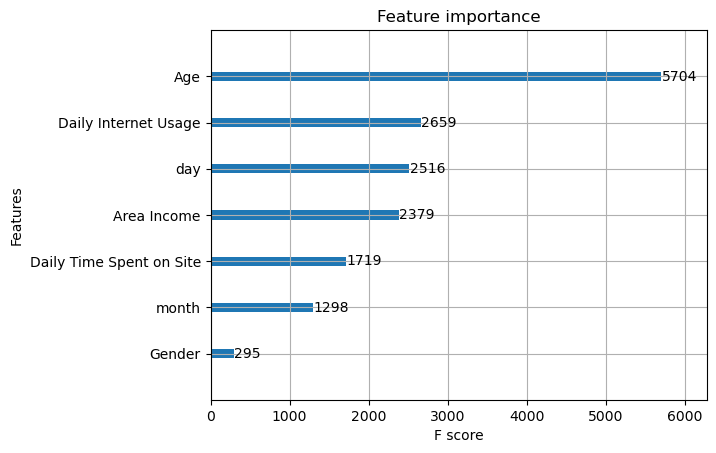

In [63]:
import xgboost as xgb

xgb.plot_importance(feature_imp_new)